# 결과 미리 요약
- 결과가 너무 안좋아서 모델 저장 X
- Conv 층 수와 Dropout이 과도했음 -> 일반화 망함
- 과도한 regularization: 총 5번 -> 아예 과소적합

- 다음 진행 요약
  - conv 층 2개로 돌리기 (64, 96)  
  - conv 층 dropout 제거 -> FC에만 0.4
  - L2 유지
  - zoom_range: 0.1로 다시 돌리기  

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],  # 좁은 범위로 조정
    rotation_range=10,
    zoom_range=0.2,  # 0.2로 확대
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [4]:
# Conv Layer 추가 + Conv Layer 뒤에 Dropout 추가
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    Dropout(0.2),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    MaxPooling2D(2),

    Conv2D(128, 3, activation="relu"),  # conv layer 추가
    BatchNormalization(),
    Dropout(0.2),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005),
            loss="binary_crossentropy", metrics=["accuracy"])

In [5]:
history=model.fit(train_generator, validation_data=val_generator,
                epochs=20, verbose=1)

Epoch 1/20
1200/1200 [==============================] - 87s 68ms/step - loss: 0.2819 - accuracy: 0.9157 - val_loss: 0.3571 - val_accuracy: 0.8895
Epoch 2/20
1200/1200 [==============================] - 78s 65ms/step - loss: 0.1515 - accuracy: 0.9683 - val_loss: 0.4394 - val_accuracy: 0.8768
Epoch 3/20
1200/1200 [==============================] - 86s 71ms/step - loss: 0.1259 - accuracy: 0.9776 - val_loss: 7.1869 - val_accuracy: 0.4996
Epoch 4/20
1200/1200 [==============================] - 81s 68ms/step - loss: 0.1054 - accuracy: 0.9830 - val_loss: 0.3436 - val_accuracy: 0.9208
Epoch 5/20
1200/1200 [==============================] - 80s 66ms/step - loss: 0.1000 - accuracy: 0.9842 - val_loss: 0.3418 - val_accuracy: 0.8794
Epoch 6/20
1200/1200 [==============================] - 77s 64ms/step - loss: 0.0954 - accuracy: 0.9851 - val_loss: 3.5117 - val_accuracy: 0.5531
Epoch 7/20
1200/1200 [==============================] - 77s 64ms/step - loss: 0.0863 - accuracy: 0.9867 - val_loss: 0.5064 -

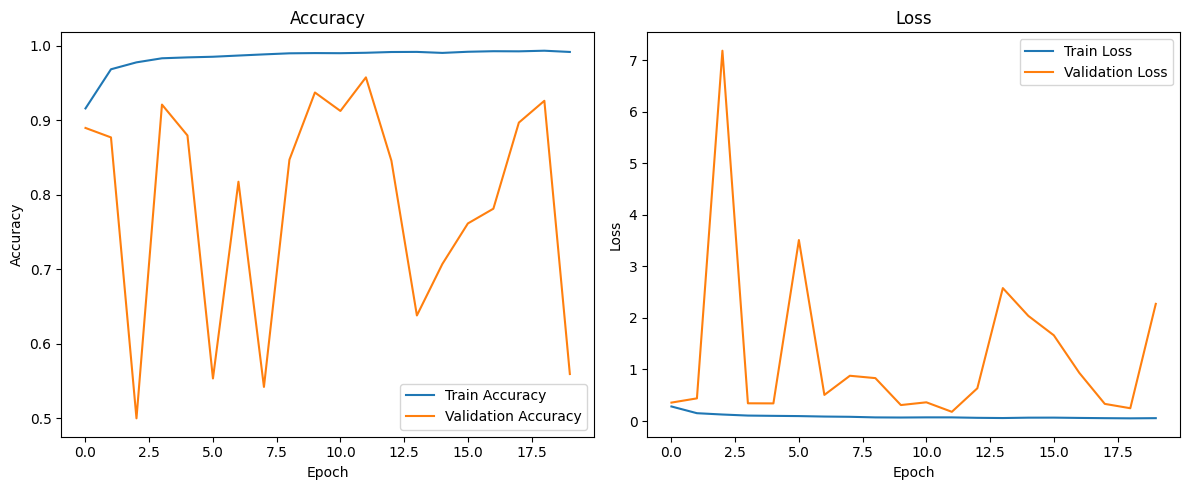

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/03_readjusted_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.61      0.34      0.44      4800
        open       0.54      0.79      0.64      4800

    accuracy                           0.56      9600
   macro avg       0.58      0.56      0.54      9600
weighted avg       0.58      0.56      0.54      9600



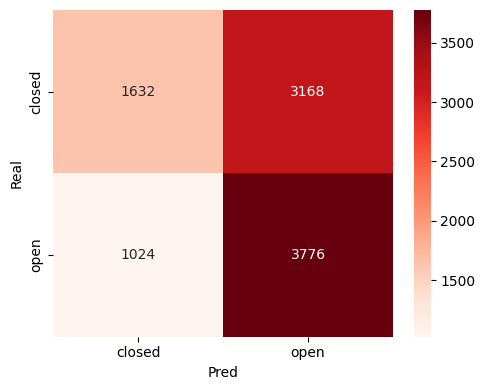

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

# classification report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)
with open("../../results/reports/03_readjusted_classification_report.txt", "w") as f:
    f.write(report)

# confusion matrix
conf_matirx=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matirx, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/03_readjusted_confusion_matrix.png")
plt.show()